# Imports

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from deep_fill_gan.model.networks import Discriminator
from deep_fill_gan.model.networks import Generator

import torch
from torchvision import transforms

import torchvision.transforms as T
import os
from skimage import feature
import argparse

from PIL import Image
import torch
import torchvision.transforms as T
from sklearn.decomposition import PCA
from skimage import feature
from scipy import ndimage


from skimage.util import view_as_blocks
import pandas as pd



# Test image load

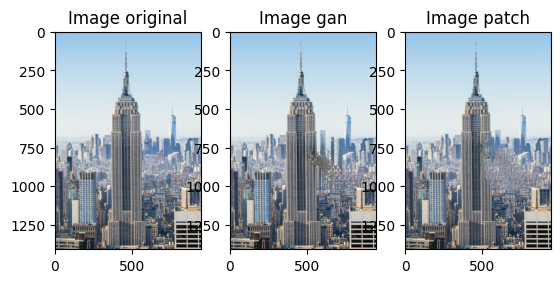

(1408, 944, 3) (1408, 944, 3) (1408, 944, 3)


In [5]:
image_GAN_path = 'examples/inpaint/base_test_images/empire_gan.png'
image_patch_path =  'examples/inpaint/base_test_images/empire_patch.png'
image_original_path =  'examples/inpaint/base_test_images/empire.jpg'

image_original = cv2.imread(image_original_path)
pixels_to_remove_x = 4
pixels_to_remove_y = 6
image_original = image_original[:-pixels_to_remove_y, :-pixels_to_remove_x]

image_GAN = cv2.imread(image_GAN_path)

#image_GAN = cv2.resize(image_GAN, (image_original.shape[1], image_original.shape[0]))
image_patch = cv2.imread(image_patch_path)
image_patch = image_patch[:-pixels_to_remove_y, :-pixels_to_remove_x]

image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
image_GAN = cv2.cvtColor(image_GAN, cv2.COLOR_BGR2RGB)
image_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2RGB)

plt.subplot(1, 3, 1)
plt.imshow(image_original)
plt.title('Image original')

plt.subplot(1, 3, 2)
plt.imshow(image_GAN)
plt.title('Image gan')

plt.subplot(1, 3, 3)
plt.imshow(image_patch)  # Use a suitable colormap
plt.title('Image patch')

plt.show()

print(image_original.shape, image_GAN.shape, image_patch.shape)

# Weighted join methods

In [6]:
def test_combination(responses_image1, responses_image2, image1, image2, name):
    # Compute normalized responses
    total_responses = responses_image1 + responses_image2
    normalized_responses1 = responses_image1 / total_responses
    normalized_responses2 = responses_image2 / total_responses

    # Combine images based on normalized responses
    selected_responses = (
        image1 * normalized_responses1[:, :, np.newaxis] +
        image2 * normalized_responses2[:, :, np.newaxis]
    )
    selected_responses = np.clip(selected_responses, 0, 255).astype(np.uint8)


    # Save the image
    #cv2.imwrite('./examples/inpaint/results/test2_combination_'+ name + '.png', cv2.cvtColor(selected_responses, cv2.COLOR_RGB2BGR))
    return selected_responses


In [7]:
def high_pass_filter(image, sigma=1):
    # Create a low-pass filter using a Gaussian kernel
    kernel_size = int(6 * sigma + 1)
    kernel_size += 1 if kernel_size % 2 == 0 else 0  # Ensure the kernel size is odd
    low_pass_filter = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

    # High-pass filter is obtained by subtracting the low-pass filter from the original image
    high_pass_filter =  cv2.subtract(image, low_pass_filter)

    return high_pass_filter

def blur(image, sigma=1):
    return ndimage.gaussian_filter(image, sigma=sigma)

def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

In [9]:
def test_hp(patch, gan, patch_intensity=3, sigma=5, show = False):
    patch = (patch / 255).astype(np.float32)
    gan = (gan / 255).astype(np.float32)

    hp_patch = np.abs(high_pass_filter(patch, sigma=sigma))
    hp_gan = np.abs(high_pass_filter(gan, sigma=sigma))

    hp_patch = cv2.cvtColor(hp_patch, cv2.COLOR_RGB2GRAY)
    hp_gan = cv2.cvtColor(hp_gan, cv2.COLOR_RGB2GRAY)

    blurred_hp_patch = blur(hp_patch, sigma=sigma)
    blurred_hp_gan = blur(hp_gan, sigma=sigma)
    
    # Calculate the mask as per the formula
    # Can adjust the sigma here (e.g. sigma=sigma * 3) to make the blender smoother
    mask = normalize(blur(np.clip(blurred_hp_patch - blurred_hp_gan, 0, 1), sigma=sigma))
    mask = np.clip(mask * patch_intensity, 0, 1)

    img_combined = (1 - mask[:,:,np.newaxis]) * gan + mask[:,:,np.newaxis] * patch
    
    if show:
    
        # Display the results
        plt.figure(figsize=(20, 10))
        
        plt.subplot(2, 5, 1)
        plt.imshow(patch, cmap='gray')
        plt.title('Patch Image')
        
        plt.subplot(2, 5, 2)
        plt.imshow(hp_patch, cmap='gray')
        plt.title('High-Pass Filtered Patch')
        
        plt.subplot(2, 5, 3)
        plt.imshow(blurred_hp_patch, cmap='gray')
        plt.title('Blurred High-Pass Patch')
        
     
        plt.subplot(2, 5, 4)
        plt.imshow(gan, cmap='gray')
        plt.title('gan Image')
        
        plt.subplot(2, 5, 5)
        plt.imshow(hp_gan, cmap='gray')
        plt.title('High-Pass Filtered gan')
        
        plt.subplot(2, 5, 6)
        plt.imshow(blurred_hp_gan, cmap='gray')
        plt.title('Blurred High-Pass gan')
    
        plt.subplot(2, 5, 7)
        plt.imshow(mask, cmap='gray')
        plt.title('Normalized Mask')
    
        
        plt.subplot(2, 5, 8)
        plt.imshow(img_combined)
        plt.title('Combined Image')
        plt.show()
    
        # display combined image for debugging
        plt.figure(figsize=(10,10))
        plt.imshow(img_combined)
        plt.show
        # display combined image for debugging
        plt.figure(figsize=(10,10))
        plt.imshow(gan)
        plt.show
    return img_combined 



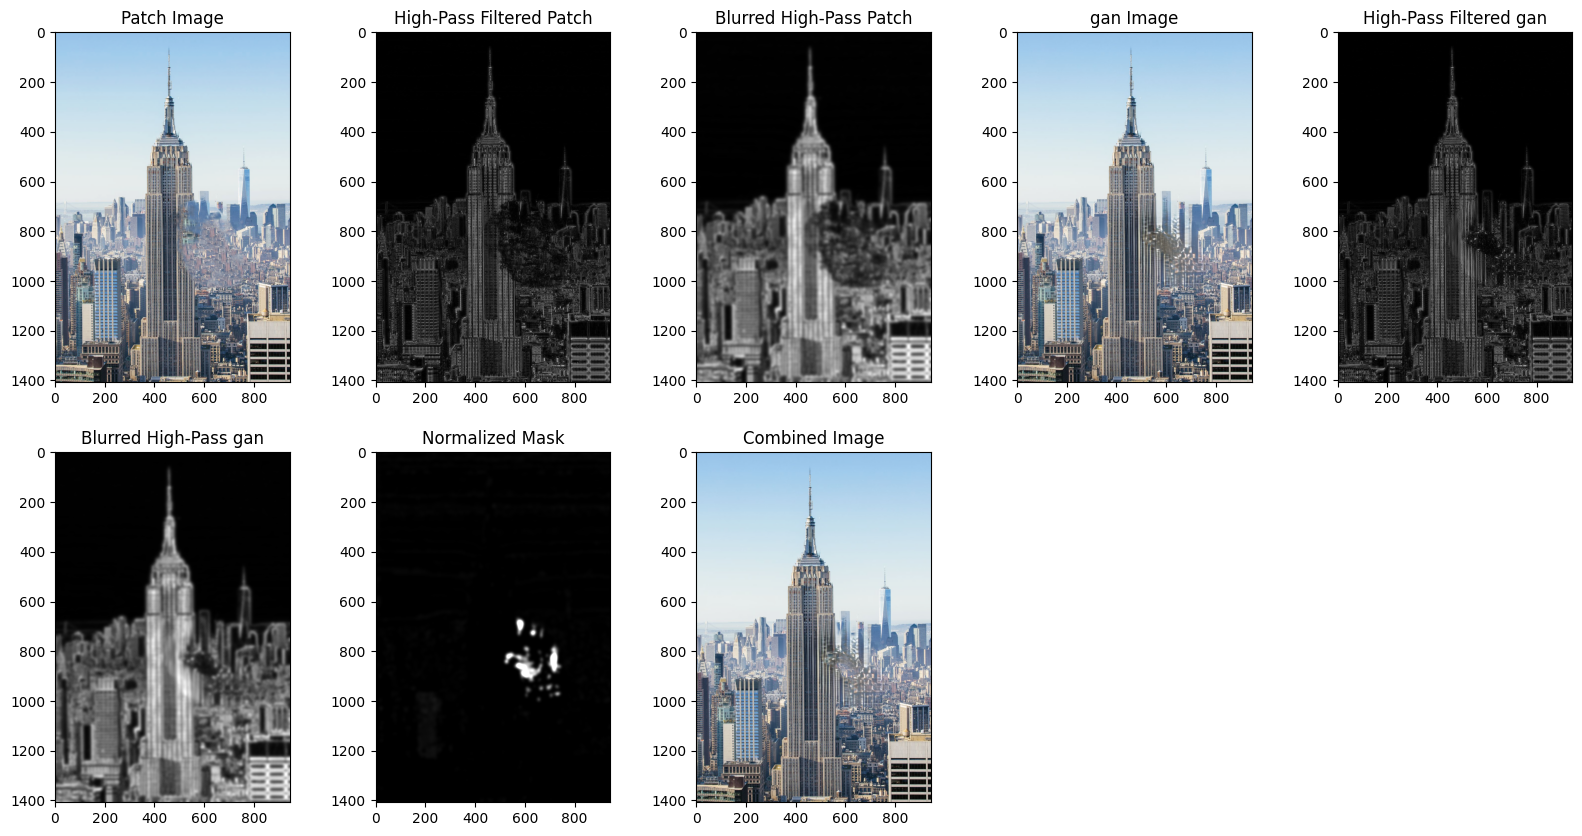

array([[[0.5959219 , 0.76862746, 0.9215687 ],
        [0.5959224 , 0.7684715 , 0.9214126 ],
        [0.59607846, 0.7684727 , 0.92156863],
        ...,
        [0.5921569 , 0.7647059 , 0.91770625],
        [0.5960208 , 0.7685698 , 0.92151093],
        [0.5960216 , 0.76857054, 0.9215117 ]],

       [[0.59592336, 0.7684724 , 0.92141354],
        [0.5960784 , 0.7684729 , 0.92156863],
        [0.59607846, 0.7686274 , 0.92156863],
        ...,
        [0.5922157 , 0.7647648 , 0.9177059 ],
        [0.5960211 , 0.76862746, 0.9215687 ],
        [0.5960219 , 0.76862746, 0.92156863]],

       [[0.59607846, 0.7684753 , 0.92156863],
        [0.59607846, 0.76862746, 0.92156863],
        [0.595928  , 0.7686274 , 0.9214182 ],
        ...,
        [0.5921569 , 0.764764  , 0.9177052 ],
        [0.5960217 , 0.76862746, 0.92156863],
        [0.5960225 , 0.7686275 , 0.92156863]],

       ...,

       [[0.15294118, 0.16470589, 0.13725491],
        [0.07450981, 0.08627451, 0.05882353],
        [0.10196079, 0

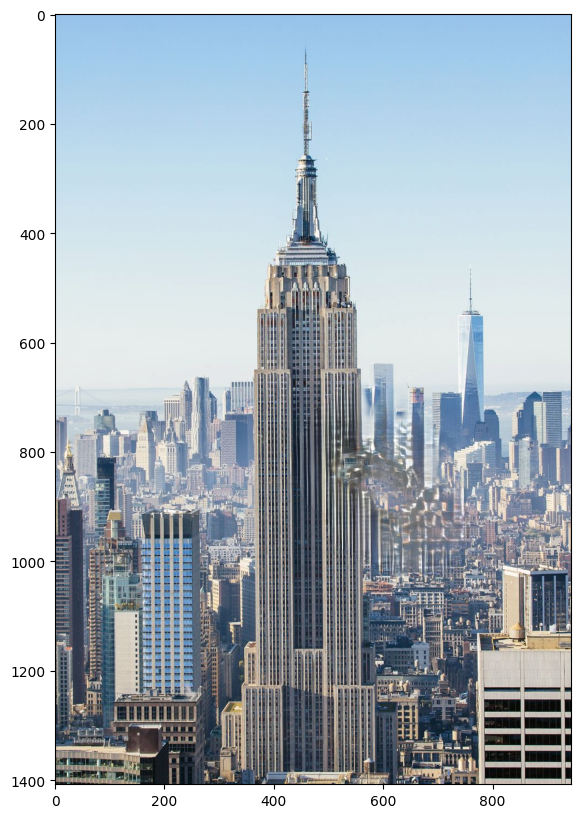

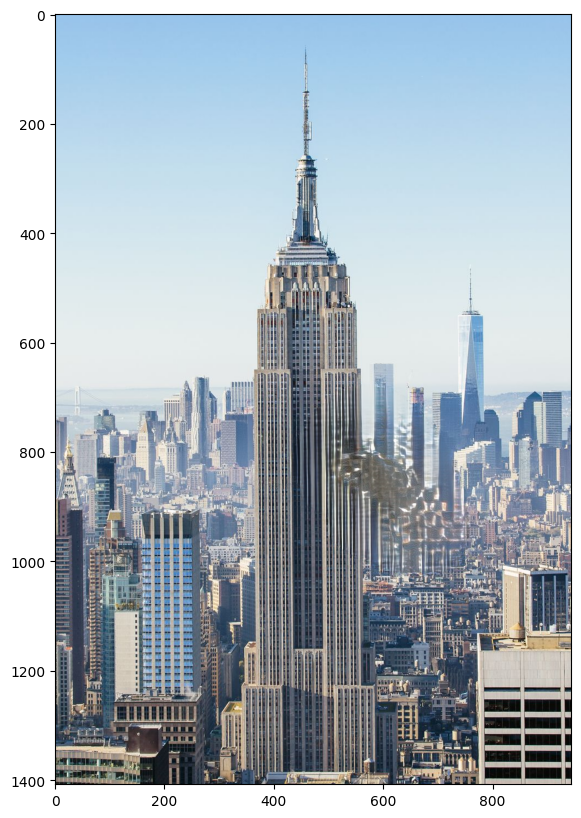

In [10]:
# sigma:            high pass and blur sigmas
# patch_intensity:  multiplier to boost patch influence on the final output (default 3)

test_hp(image_patch, image_GAN, patch_intensity=3, sigma=5, show= True)

# Metrics

In [11]:
def calculate_metrics(original_image, new_image):
    mse_noise = mean_squared_error(original_image, new_image)
    ssim_noise = ssim(original_image, new_image,
                   full=True,win_size=3)
    PSNR = peak_signal_noise_ratio(original_image, new_image) 
    
    return mse_noise, ssim_noise[0], PSNR

    

# Gabor response

In [12]:
def apply_gabor_filters(image, scales, orientations):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    responses = []

    for scale in scales:
        for orientation in orientations:
            # Apply Gabor filter
            gabor_kernel = cv2.getGaborKernel(
                (11, 23), # Size of the filter
                scale, # Standard deviation of the Gaussian envelope
                orientation,  # Orientation of the normal to the Gabor function
                10.0,  # Wavelength of the sinusoidal factor
                0.8,  # Spatial aspect ratio
                0,  # Phase offset
                ktype=cv2.CV_32F
            )
            gabor_response = cv2.filter2D(gray_image, cv2.CV_32F, gabor_kernel)
            responses.append(gabor_response)

    return responses

In [13]:
def compute_texturization_percentage(responses, method='magnitude', visualize=False, threshold=0.5):
    # Normalize each response separately
    normalized_responses = [np.abs(response) / np.max(np.abs(response)) for response in responses]

    if method == 'magnitude':
        # Compute the magnitude or energy of the Gabor responses at each pixel
        magnitude_responses = np.sqrt(np.sum(np.square(normalized_responses), axis=0))

        # Aggregate by taking the Euclidean norm (magnitude)
        aggregated_responses = magnitude_responses

    elif method == 'pca':
        # Reshape responses to (num_orientations, num_pixels) for PCA
        reshaped_responses = np.vstack([response.flatten() for response in normalized_responses]).T

        # Apply PCA to find the principal component
        pca = PCA(n_components=1)
        principal_component = pca.fit_transform(reshaped_responses)

        # Reshape the principal component back to the original image shape
        aggregated_responses = principal_component.reshape(image.shape)
    elif method == 'max':  
         aggregated_responses = np.max(np.stack(normalized_responses), axis=0)
    elif method == 'mean':
        aggregated_responses = np.mean(np.stack(normalized_responses), axis=0)

    elif method == 'sum':
        aggregated_responses = np.sum(np.stack(normalized_responses), axis=0) 


    else:
        raise ValueError("Invalid method. Supported methods are 'magnitude' and 'pca'.")


    # Count the number of pixels above the threshold
    #above_threshold_pixels = np.sum(aggregated_responses > threshold)

    # Compute the percentage of heavily texturized pixels
    #total_pixels = np.prod(aggregated_responses.shape)
    #percentage_texturized = (above_threshold_pixels / total_pixels) * 100

    if visualize:
        visualize_above_threshold_and_max_response(aggregated_responses)

    return aggregated_responses


In [14]:
def visualize_above_threshold_and_max_response(max_responses):
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    # Max Response
    axes.imshow(max_responses)
    axes.set_title('Max Response')
    axes.axis('off')


    plt.tight_layout()
    plt.show()

In [15]:
def visualize_response_map(responses, scales, orientations):
    num_scales = len(scales)
    num_orientations = len(orientations)

    fig, axes = plt.subplots(num_scales, num_orientations, figsize=(12, 12))

    for i in range(num_scales):
        for j in range(num_orientations):
            index = i * num_orientations + j
            ax = axes[i, j] if num_scales > 1 else axes[j]

            response = responses[index]

            ax.imshow(response)
            ax.set_title(f'Scale: {scales[i]}, Orientation: {orientations[j]}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
scales = [8]
orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


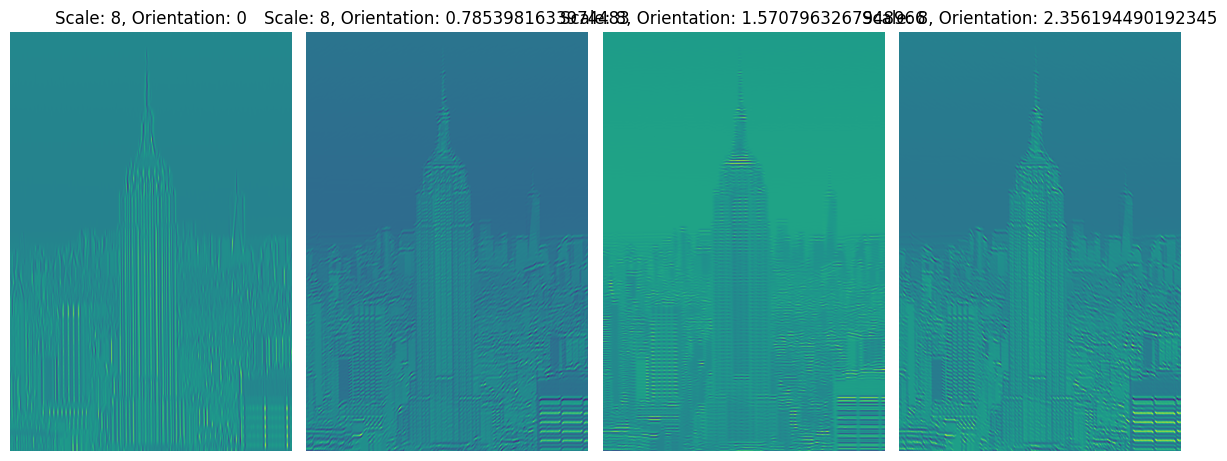

In [17]:
responses_original = apply_gabor_filters(image_original, scales, orientations)
responses_GAN = apply_gabor_filters(image_GAN, scales, orientations)
responses_patch = apply_gabor_filters(image_patch, scales, orientations)

visualize_response_map(responses_original, scales, orientations)

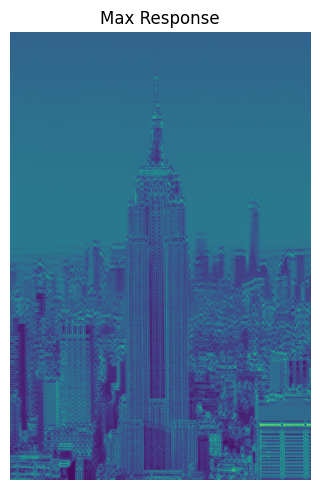

In [18]:
# Compute texturization score
max_response_original = compute_texturization_percentage(responses_original, visualize=True)

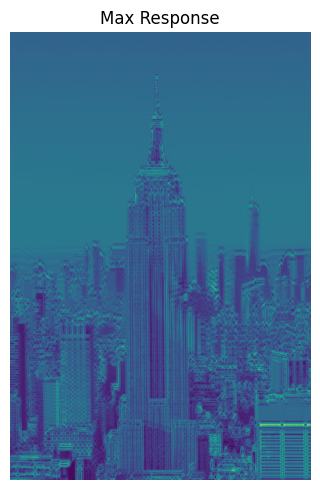

In [19]:
max_response_GAN = compute_texturization_percentage(responses_GAN, visualize=True)


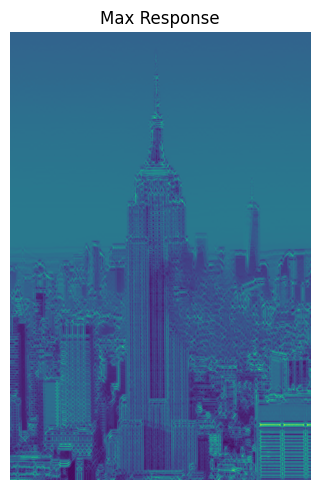

In [20]:
max_response_patch = compute_texturization_percentage(responses_patch, visualize=True)


In [23]:
combination = test_combination(max_response_GAN, max_response_patch, image_GAN, image_patch, "empire")

In [24]:
calculate_metrics(image_original, image_GAN)
calculate_metrics(image_original, image_patch)
calculate_metrics(image_original, combination)


(100.98862257038071, 0.9623111464428786, 28.088079121667327)

# GANS

In [32]:
def run_for_gans(image, mask, name, out_route = './examples/inpaint/results_deepfill/' , checkpoint = 'deep_fill_gan/pretrained/pre_trained_official_pt.pth' ):
    generator_state_dict = torch.load(checkpoint)['G']
 

    use_cuda_if_available = True
    device = torch.device('cuda' if torch.cuda.is_available()
                          and use_cuda_if_available else 'cpu')

    # set up network
    generator = Generator(cnum_in=5, cnum=48, return_flow=False).to(device)

    generator_state_dict = torch.load(checkpoint)['G']
    generator.load_state_dict(generator_state_dict, strict=True)



    # prepare input
    image = T.ToTensor()(image)
    mask = T.ToTensor()(mask)
    _, h, w = image.shape
    grid = 8

    image = image[:3, :h//grid*grid, :w//grid*grid].unsqueeze(0)
    mask = mask[0:1, :h//grid*grid, :w//grid*grid].unsqueeze(0)

    print(f"Shape of image: {image.shape}")

    image = (image*2 - 1.).to(device)  # map image values to [-1, 1] range
    mask = (mask > 0.5).to(dtype=torch.float32,
                           device=device)  # 1.: masked 0.: unmasked

    image_masked = image * (1.-mask)  # mask image

    ones_x = torch.ones_like(image_masked)[:, 0:1, :, :]
    x = torch.cat([image_masked, ones_x, ones_x*mask],
                  dim=1)  # concatenate channels

    with torch.inference_mode():
        x_stage1, x_stage2 = generator(x, mask)

    # complete image
    image_inpainted = image * (1.-mask) + x_stage2 * mask

    # save inpainted image
    img_out = ((image_inpainted[0].permute(1, 2, 0) + 1)*127.5)
    img_out = img_out.to(device='cpu', dtype=torch.uint8)
    img_out = Image.fromarray(img_out.numpy())
    img_out.save(out_route + name)

      # complete image
    image_inpainted = image * (1.-mask) + x_stage1 * mask

    # save inpainted image
    img_out = ((image_inpainted[0].permute(1, 2, 0) + 1)*127.5)
    img_out = img_out.to(device='cpu', dtype=torch.uint8)
    img_out = Image.fromarray(img_out.numpy())
    img_out.save(out_route+ "stage1/" + name)


In [35]:
def create_gan_inpaints():
    original_path = './examples/inpaint/test_images/'
    mask_path = './examples/inpaint/masks/'
    
    image_files = [f for f in os.listdir(original_path) if f.endswith(('.png', '.jpg', '.jpeg'))]


    # Iterate through each image file
    for image_file in image_files:
        print(image_file)
        name = image_file.split(".")[0]
        
        mask_name = name + "_mask.png"
        mask_file = mask_path + mask_name
        image_file = original_path  + image_file
        image = Image.open(image_file)
        mask = Image.open(mask_file)
        run_for_gans(image, mask, name +".png")




In [36]:
create_gan_inpaints()

fence.png
Shape of image: torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
toronto.png
Shape of image: torch.Size([1, 3, 344, 616])
torch.Size([1, 3, 344, 616])
cartagena2.png
Shape of image: torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
forest.png
Shape of image: torch.Size([1, 3, 368, 640])
torch.Size([1, 3, 368, 640])
night.png
Shape of image: torch.Size([1, 3, 1000, 664])
torch.Size([1, 3, 1000, 664])
cartagena.png
Shape of image: torch.Size([1, 3, 512, 768])
torch.Size([1, 3, 512, 768])
nature.png
Shape of image: torch.Size([1, 3, 504, 1000])
torch.Size([1, 3, 504, 1000])


# Run join for all images

## Helper functions

In [37]:
def resize_image(image, target_size):    
    # Calculate pixels to remove for resizing
    pixels_to_remove_x = image.shape[1] - target_size[1]
    pixels_to_remove_y = image.shape[0] - target_size[0]

    # Resize the image
    resized_image = image[:image.shape[0] - pixels_to_remove_y, :image.shape[1] - pixels_to_remove_x]

    # Convert BGR to RGB
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    return resized_image

In [38]:
def get_images(path_original, path_patch, path_gan, mask, difussion, rpnn,  show = False):
    image_original = cv2.imread(path_original)
    image_patch = cv2.imread(path_patch)
    image_GAN = cv2.imread(path_gan)
    image_mask = cv2.imread(mask)
    image_difussion = cv2.imread(difussion)
    image_rpnn = cv2.imread(rpnn)
   
    
    target_size = np.minimum.reduce([image_GAN.shape, image_original.shape, image_patch.shape, image_mask.shape,  image_difussion.shape,  image_rpnn.shape])

    # Resize each image
    image_original = resize_image(image_original, target_size)
    image_GAN = resize_image(image_GAN, target_size)
    image_patch = resize_image(image_patch, target_size)
    image_mask = resize_image(image_mask, target_size)
    image_difussion = resize_image(image_difussion, target_size)
    image_rpnn = resize_image(image_rpnn, target_size)
    
        
    if show:
        plt.figure(figsize=(15, 5))  # Adjust width and height as needed
        plt.subplot(1, 3, 1)
        plt.imshow(image_original)
        plt.title('Image original')
        
        plt.subplot(1, 3, 2)
        plt.imshow(image_GAN)
        plt.title('Image gan')
        
        plt.subplot(1, 3, 3)
        plt.imshow(image_patch)  # Use a suitable colormap
        plt.title('Image patch')
        
        plt.show()
        
        print(image_original.shape, image_GAN.shape, image_patch.shape)
    return image_original, image_GAN, image_patch, image_mask, image_difussion, image_rpnn
    

In [39]:
def draw_results(original, images, titles, name = "default"):
    metrics_df = pd.DataFrame(columns=['MSE', 'SSIM', 'PSNR'])

    num_images = len(images)
    
    # Calculate number of rows and columns based on the number of images
    num_rows = (num_images + 2) // 3  # Adjust as needed
    num_cols = min(3, num_images)
    
    # Set the figure size based on the number of rows and columns
    plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    
    for i in range(num_images):
        # Calculate metrics for the current image
        metrics = calculate_metrics(original, images[i])
        metrics_df.loc[titles[i]] =  tuple(round(metric, 1) for metric in metrics)

        # Plot the current image
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')

        
        # Display metrics as text with a white background
        mse, ssim, psnr = metrics
        plt.text(0.05, 0.95, f'MSE: {mse:.2f}\nSSIM: {ssim:.2f}\nPSNR: {psnr:.2f}', color='black', fontsize=15, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    # Show all the plots together
    plt.tight_layout()
    plt.savefig("./examples/inpaint/results_all/"+ name)
    plt.tight_layout()
    plt.show()

    metrics_df_transposed = metrics_df.transpose()

    print("\nMetrics Table:")
    print(metrics_df_transposed)

## Run join methods

In [45]:
def run_compare_all():
    gan_path = './examples/inpaint/results_deepfill/'
    patch_path = './examples/inpaint/results_mpnn/'
    masked = './examples/inpaint/test_images/'
    difussion_path = './examples/inpaint/results_diffusion/'
    rpnn_path = './examples/inpaint/results_rpnn/'
    original_path = './examples/inpaint/test_images/unmodified/'
    
    
    # List all files in the folder
    images_original = [f for f in os.listdir(original_path) if f.endswith(('.png'))]
    
    
    # Iterate through each image file
    for image_original in images_original:
        name = image_original.split(".")[0]
        original, gan, patch, mask, diffusion, rpnn = get_images(original_path+image_original, patch_path+image_original, gan_path+image_original, masked+image_original, difussion_path + image_original, rpnn_path + image_original )
        responses_GAN = apply_gabor_filters(gan, scales, orientations)
        responses_patch = apply_gabor_filters(patch, scales, orientations)

        
        max_response_patch = compute_texturization_percentage(responses_patch, method='max', visualize=False)
        max_response_GAN = compute_texturization_percentage(responses_GAN, method= "max",visualize=False)
        
        high_pass = test_hp(patch, gan, patch_intensity=3, sigma=5)
        high_pass = (high_pass * 255).astype('uint8')

        comb = test_combination(max_response_patch, max_response_GAN, patch, gan, name)


        images = [gan, patch,diffusion, high_pass, comb, rpnn  ]
        titles = ['GAN', 'MPNN', "Diffusion", "High pass",  "Gabor", "RPNN" ]
        draw_results(original, images, titles, name) 


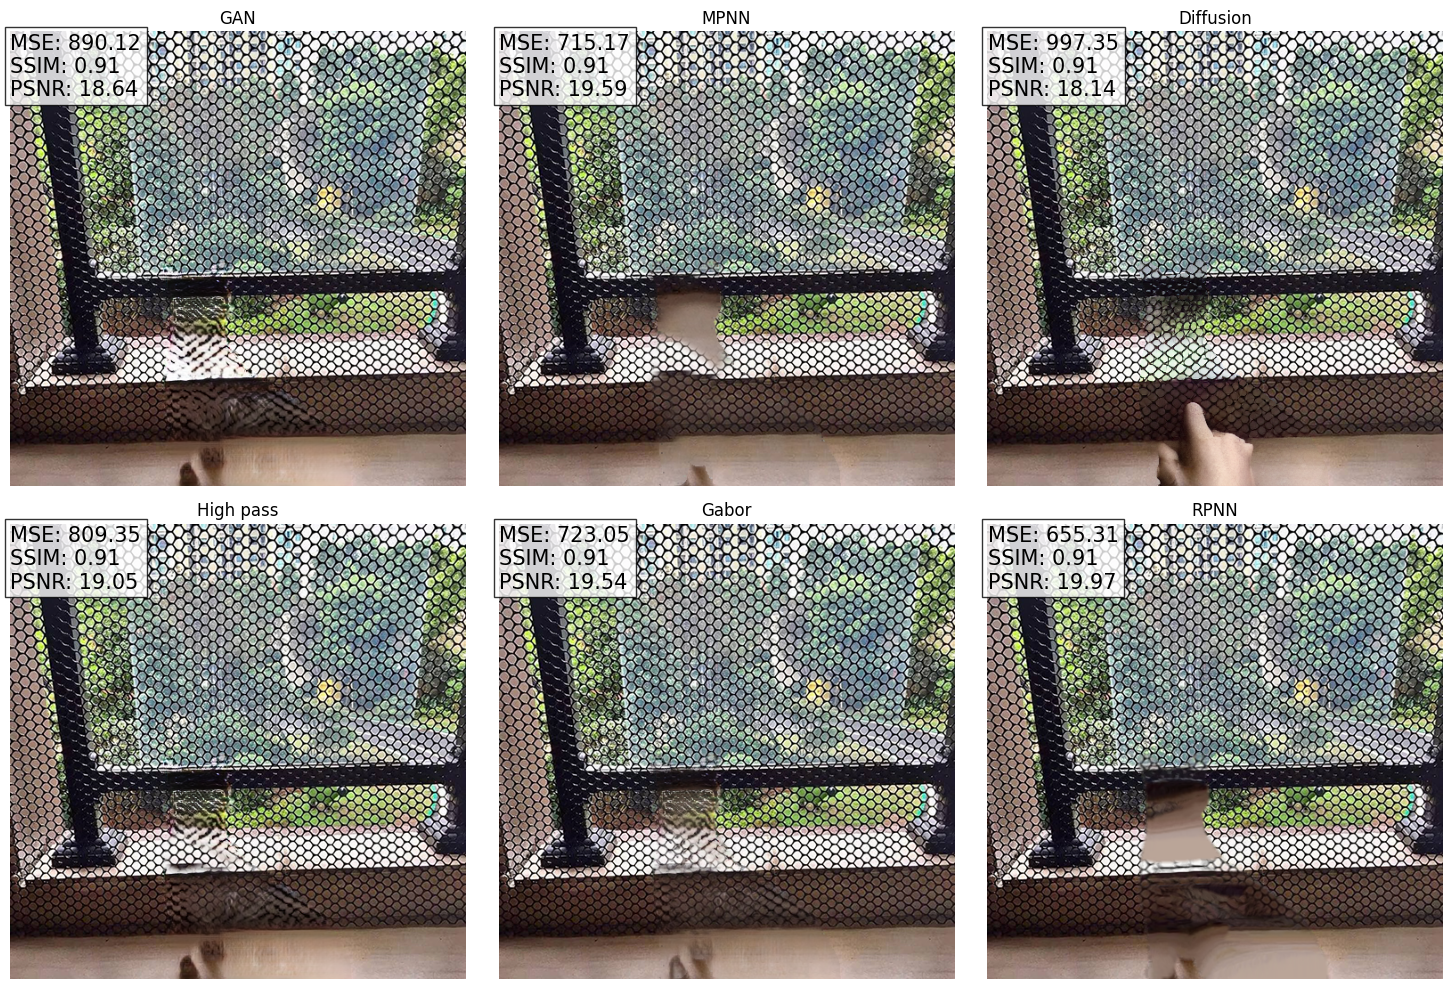


Metrics Table:
        GAN   MPNN  Diffusion  High pass  Gabor   RPNN
MSE   890.1  715.2      997.3      809.3  723.1  655.3
SSIM    0.9    0.9        0.9        0.9    0.9    0.9
PSNR   18.6   19.6       18.1       19.0   19.5   20.0


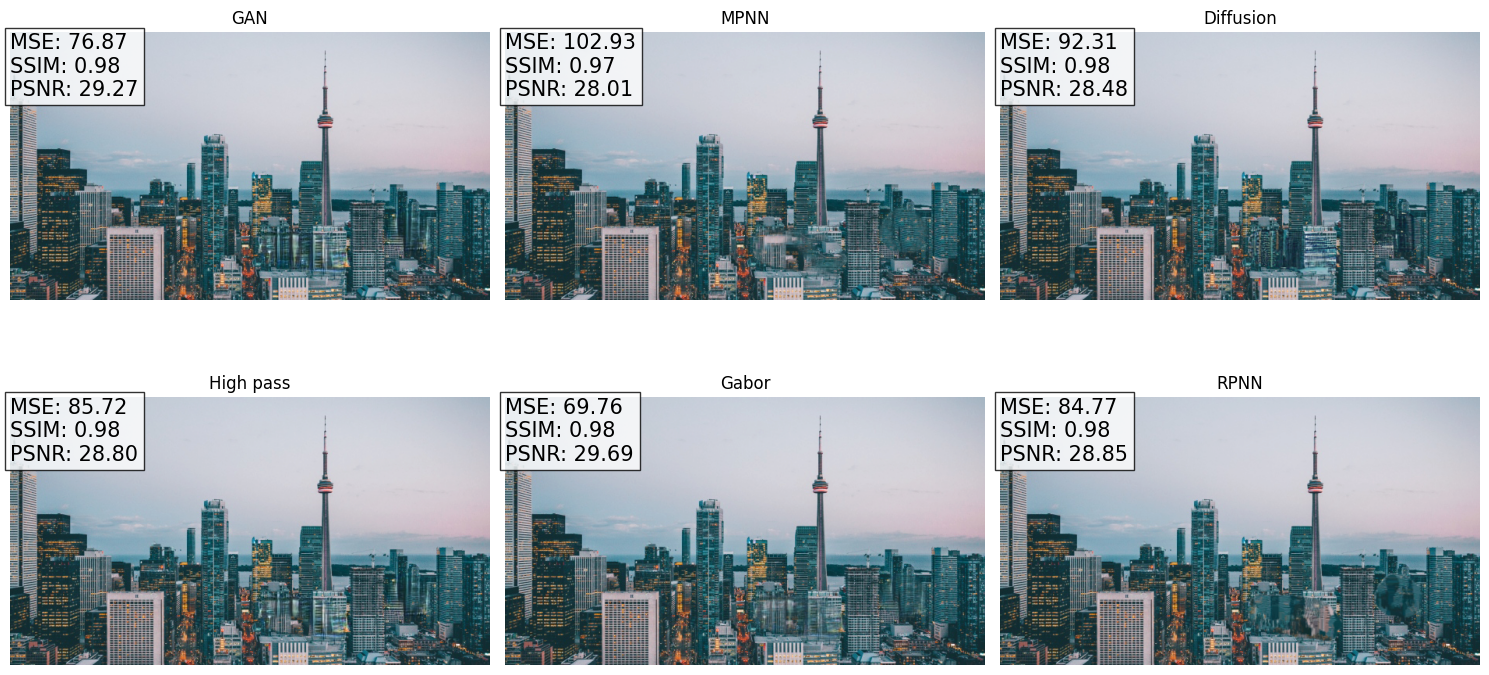


Metrics Table:
       GAN   MPNN  Diffusion  High pass  Gabor  RPNN
MSE   76.9  102.9       92.3       85.7   69.8  84.8
SSIM   1.0    1.0        1.0        1.0    1.0   1.0
PSNR  29.3   28.0       28.5       28.8   29.7  28.8


In [ ]:
run_compare_all()

# Real or Fake

In [ ]:
def load_model(checkpoint = './G_optim_ep_82.pth'):
    generator_state_dict = torch.load(checkpoint)['G']


        from model.networks import Generator

    use_cuda_if_available = True
    device = torch.device('cuda' if torch.cuda.is_available()
                          and use_cuda_if_available else 'cpu')

    config['resolution'] = utils.imsize_dict[config['dataset']]
    print("RESOLUTION: ",config['resolution'])
    config['n_classes'] = utils.nclass_dict[config['dataset']]
    config['G_activation'] = utils.activation_dict[config['G_nl']]
    config['D_activation'] = utils.activation_dict[config['D_nl']]
    # set up network
    generator = Generator(**config)).to(device)

    generator_state_dict = torch.load(checkpoint)['G']
    generator.load_state_dict(generator_state_dict, strict=True)